In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"manasgpt1305","key":"697646038f0e3d5ecc44e6ffe012ebcc"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)    2GB  2020-05-13 22:21:42          65567  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                          142MB  2020-04-29 22:47:23           8383  
jessemostipak/animal-crossing                               Animal Crossing                                     754KB  2020-05-04 15:30:32            405  
mrmorj/political-advertisements-from-facebook               Political Advertisements from Facebook              237MB  2020-05-05 18:53:51             60  
timxia/enriched-global-mobility-data-apple-google           Enri

In [ ]:
!kaggle datasets list -s flickr30k

ref                              title                 size  lastUpdated          downloadCount  
-------------------------------  --------------------  ----  -------------------  -------------  
hsankesara/flickr-image-dataset  Flickr Image dataset   8GB  2018-06-12 20:34:20           6795  
jacksoncrow/word2vec-flickr30k   Word2Vec Flickr30k     3GB  2019-11-30 14:31:14              3  
ritchie46/flickr30khistograms    flickr30k-histograms  39MB  2020-04-26 10:53:13              6  
vshine/flickr30k-results         flickr30k_results      4MB  2019-05-07 13:59:24             16  
koishi/photovspaint              photovspaint           7GB  2019-12-03 16:17:36              1  
adityajn105/flickr30k            Flick 30k Dataset      8GB  2020-04-27 08:07:18             16  


In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [03:08<00:00, 53.3MB/s]
100% 8.16G/8.16G [03:08<00:00, 46.4MB/s]


In [ ]:
!unzip /content/{/content}/datasets/hsankesara/flickr-image-dataset/flickr-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535529555.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356236664.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5356318668.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/535830521.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5359437945.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361355399.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/53614287.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536147209.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5361551308.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/536156200.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/5362687336.jpg  
  inflating: flickr30k_images/flickr30k_images/flickr30k_images/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add


In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions  = readTextFile("/content/flickr30k_images/results.csv")
captions = captions.split('\n')[:-1]
captions[1]

'1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .'

In [ ]:
print(len(captions))

158916


In [ ]:
captions

['image_name| comment_number| comment',
 '1000092795.jpg| 0| Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 '1000092795.jpg| 1| Two young , White males are outside near many bushes .',
 '1000092795.jpg| 2| Two men in green shirts are standing in a yard .',
 '1000092795.jpg| 3| A man in a blue shirt standing in a garden .',
 '1000092795.jpg| 4| Two friends enjoy time spent together .',
 '10002456.jpg| 0| Several men in hard hats are operating a giant pulley system .',
 '10002456.jpg| 1| Workers look down from up above on a piece of equipment .',
 '10002456.jpg| 2| Two men working on a machine wearing hard hats .',
 '10002456.jpg| 3| Four men on top of a tall structure .',
 '10002456.jpg| 4| Three men on a large rig .',
 '1000268201.jpg| 0| A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201.jpg| 1| A little girl in a pink dress going into a wooden cabin .',
 '1000268201.jpg| 2| A little girl climbing the stairs 

In [ ]:
first  = captions[1].split("|")
#second = first.split(",")
#print(first.split(".")[0])
#print(second)
first
second = first[-1]
second
img_name = first[0].split(".")[0]
img_name

NameError: ignored

In [ ]:
descriptions = {}

for x in captions:
    first = x.split("|")
    second = first[-1]
    img_name = first[0].split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)

In [ ]:
descriptions["1010673430"]

[' A little girl in a pink shirt and a little girl in an orange shirt sitting in the grass .',
 ' Two young children eating a snack and playing in the grass .',
 ' Two young toddlers outside on the grass .',
 ' Two infants are at play in the yard .',
 ' 2 female babies eating chips .']

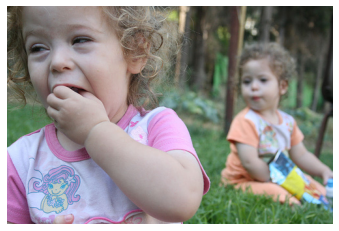

In [ ]:
IMG_PATH = "/content/flickr30k_images/flickr30k_images/flickr30k_images/"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1010673430.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
clean_text("A cat is sitting over the house # 64")

'cat is sitting over the house'

In [ ]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1001573224"]

['five ballet dancers caught mid jump in dancing studio with sunlight coming through window',
 'ballet dancers in studio practice jumping with wonderful form',
 'five girls are leaping simultaneously in dance practice room',
 'five girls dancing and bending feet in ballet class',
 'ballet class of five girls jumping in sequence']

In [ ]:
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [ ]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 18055


In [ ]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 1679081


In [ ]:

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

18055


In [ ]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words))

5118


In [ ]:
train_file_data = readTextFile("/content/train.txt")
test_file_data = readTextFile("/content/test.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:5]

['3359636318', '6959556104', '2326294409', '2494088238', '3892428805']

In [ ]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["3359636318"]

['startseq two people are talking outside of the video game shop next door to the mobile phone store endseq',
 'startseq group of people are standing in front of some stores endseq',
 'startseq people stand on sidewalk outside of retail stores endseq',
 'startseq people walking or talking on city street endseq',
 'startseq several people in front of stores endseq']

In [ ]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:

def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [ ]:
print(encode_image(IMG_PATH+"3359636318.jpg"))

[0.10323873 0.80791116 0.00127816 ... 0.01382212 0.6345591  1.1543261 ]


In [ ]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [ ]:
!mkdir saved

In [ ]:
with open("saved/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 19.2433123588562


In [ ]:
with open("saved/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [ ]:
len(total_words)

5118

In [ ]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
print(len(idx_to_word))

5118


In [ ]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 5121


In [ ]:
word_to_idx["black"]

20

In [ ]:
max_len = 0 
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

74


In [ ]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0] #library in keras
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [ ]:
!kaggle datasets download -d watts2/glove6b50dtxt

 61% 41.0M/67.7M [00:00<00:00, 123MB/s]
100% 67.7M/67.7M [00:00<00:00, 138MB/s]


In [ ]:
'chmod 600 /root/.kaggle/kaggle.json'

'chmod 600 /root/.kaggle/kaggle.json'

In [ ]:
!unzip /content/{/content}/datasets/watts2/glove6b50dtxt/glove6b50dtxt.zip

Archive:  /content/{/content}/datasets/watts2/glove6b50dtxt/glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


In [ ]:
f = open("/content/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [ ]:
f.close()

In [ ]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(5121, 50)

In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [ ]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 74, 50)       256050      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model?

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [ ]:
epochs = 5
batch_size = 3
steps = len(train_descriptions)//10

In [ ]:
for i in range(epochs):
  generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  model.save('/content/model_weights1'+str(i)+'.h5')

Epoch 1/1
 127/7073 [..............................] - ETA: 22:00 - loss: 3.5051

In [ ]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

In [ ]:
plt.style.use("seaborn")
def Runtime(x):
  img = encode_image('/content/'+x+'.jpg')
  img = img.reshape((1,2048))
  caption = predict_caption(img)
  return (caption)
  plt.title(caption)
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [ ]:
Runtime("WIN_20200123_12_44_22_Pro")

'man in black shirt and black hat is holding camera'

In [ ]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("/content/flickr30k_images/flickr30k_images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)